##### Initial load and inspection of the dataset

**The code:**

- Imports `pandas`.
- Loads the `ScotlandNews.csv` file into a DataFrame called `df`.
- Prints basic information about the dataset (`df.info()`) and shows the first few rows (`df.head()`).

**Goal and question**

Our overarching question is: **“Which groups (people/subjects) are most represented in these cost of living–related government news releases?”**  
Before we can do anything about representation or groups, we need to understand what the raw data look like: how many rows, which columns, and their types.

**Expected output**

- Number of rows and columns.
- Column names: we expect `texts`, `titles`, and `dates` (plus a redundant index column).
- Data types: `texts` and `titles` should be `object` (strings), `dates` will initially be strings.
- In `df.head()`, you can visually confirm that each row is one article and that the text is long, press-release style.


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("ScotlandNews.csv", encoding="utf-8")

# Preview the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  196 non-null    int64 
 1   texts       196 non-null    object
 2   dates       196 non-null    object
 3   titles      196 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.3+ KB


,Unnamed: 0,texts,dates,titles
0,1,\n \n ...,5/26/2023,Bringing down the carbon footprint in the NHS
1,2,\n \n ...,5/25/2023,Financial strategy published
2,3,\n \n ...,5/25/2023,Visitor levy legislation introduced
3,4,\n \n ...,5/25/2023,Keeping the Promise
4,5,\n \n ...,5/24/2023,American Foulbrood found in Perthshire beehive


### 1. Initial cleaning: drop redundant column, tidy text, parse dates

**The code:**

- Reloads the same CSV (`ScotlandNews.csv`) into `df`.
- Drops the redundant `Unnamed: 0` column, which is just an index from a previous export.
- Strips extra whitespace and newlines from the `texts` and `titles` columns.
- Converts the `dates` column from strings into proper `datetime` objects.

**How this relates to our question**

To analyse **who is represented** in the text, we need clean and reliable metadata:
- Removing the redundant index column keeps the table tidy.
- Cleaning whitespace makes later text processing and pattern matching more robust.
- Parsing dates allows us to later look at **trends over time** (e.g. whether attention to certain groups changes across months/years).

**Expected  output**

- `df.head()` should show:
  - `titles` and `texts` without leading/trailing spaces or messy line breaks.
  - `dates` as actual dates rather than raw strings.
- This prepares the data for all subsequent steps.


In [2]:
import pandas as pd

# Load data
df = pd.read_csv("ScotlandNews.csv", encoding="utf-8")

# Drop redundant column OR rename it to identfy entries (dropped)
df.drop(columns=["Unnamed: 0"], inplace=True)

# Clean whitespace and newline characters (regex is a way to set rules and criteria for cleaning the items)
df["texts"] = df["texts"].str.replace(r"\s+", " ", regex=True).str.strip()
df["titles"] = df["titles"].str.strip()

# Convert date to datetime (we need to transform to a usable format)
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")

df.head()

,texts,dates,titles
0,Delivering more environmentally sustainable ca...,2023-05-26,Bringing down the carbon footprint in the NHS
1,"Plan to grow economy, target spending and deli...",2023-05-25,Financial strategy published
2,Councils empowered to raise money for local to...,2023-05-25,Visitor levy legislation introduced
3,Minister responds to major report on redesigni...,2023-05-25,Keeping the Promise
4,Beekeepers within 3km of affected hive encoura...,2023-05-24,American Foulbrood found in Perthshire beehive


### 2. Create a basic cleaned text column

**The code**

- Imports `re` for regular expressions.
- Defines a `clean_text` function that:
  - lowercases text,
  - removes URLs,
  - strips out all characters except letters and spaces,
  - collapses multiple spaces into a single space.
- Applies this function to the `texts` column and stores the result in a new `clean_text` column.

**How this relates to our question**

To detect **groups** such as “children”, “disabled people”, “low-income families”, etc., we want a relatively standard, noise-reduced version of the text. This step creates a **normalised text representation** that makes word counting and keyword searches more reliable.

**Expected output**

- Check a few values of `df["clean_text"]`:
  - everything is lowercase,
  - no punctuation or URLs,
  - spaces look normal.
- This column is useful for simple frequency analysis and keyword-based group detection.


In [3]:
import re


def clean_text(text):
    text = str(text).lower() #conforming all text to lowercase avoids downstream issues with processing
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text


df["clean_text"] = df["texts"].apply(clean_text)

### 3. More robust text pre-processing (encoding fixes, whitespace, dates)

**The code**

- Imports `pandas` and `re` again (for completeness).
- Reloads the CSV and drops `Unnamed: 0` as before.
- Tries to import `ftfy` and, if available, uses it to fix text encoding issues (e.g. “â€™” → “’”, “Â£” → “£”).
- If `ftfy` is not installed, keeps the original `texts` unchanged.
- Normalises whitespace in `texts_clean_raw` (removes extra newlines and spaces).
- Parses the `dates` column into `datetime`.

**How this relates to our question**

The raw press releases contain **encoding artefacts** from scraping (odd characters for quotes and currency symbols). Fixing those improves:
- readability for humans,
- accuracy of patterns like “£”, apostrophes, and names.

Clean text makes it easier to **spot and extract groups and social categories**.

**Expected output**

- `texts_clean_raw` should look like a single, clean block of text per article, with odd characters corrected.
- Dates should again be real datetime values.
- This column (`texts_clean_raw`) becomes the basis for splitting background sections and further processing.


In [4]:
import re

import pandas as pd

df = pd.read_csv("ScotlandNews.csv", encoding="utf-8")
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

# fix mis-decoding 
try:
    from ftfy import fix_text

    df["texts_clean_raw"] = df["texts"].apply(fix_text)
except ImportError:
    df["texts_clean_raw"] = df["texts"]

# Normalise whitespace
df["texts_clean_raw"] = df["texts_clean_raw"].str.replace(r"\s+", " ", regex=True).str.strip()

# Parse dates
df["dates"] = pd.to_datetime(df["dates"], errors="coerce")

### 4. Split main article text from the ‘Background’ section

**The code**

- Defines a function `split_background` that:
  - Splits each article’s full text at the first occurrence of `" Background"`.
  - Returns:
    - `main_text` (everything before “Background”),
    - `background_text` (everything after, or empty if there is no background section).
- Applies this function to `texts_clean_raw` and creates two new columns: `main_text` and `background_text`.

**How this relates to our question**

Many government news items have a **main narrative** plus a **Background** section with extra details:
- The main text often frames **who is being helped/affected** (e.g. families, disabled people, rural communities).
- The background may contain **definitions, statistics or lists of groups** (e.g. child poverty breakdowns).

Separating these gives the option to:
- analyse them together, OR
- treat the background as more “technical/statistical” material.

**Expected output**

- For an article with a clearly labelled “Background” section, check that:
  - `main_text` stops before “Background”.
  - `background_text` starts after “Background”.
- For articles without “Background”, `background_text` should be empty.


In [5]:
def split_background(text):
    parts = text.split(" Background", 1)  # capital B from sample
    main = parts[0].strip()
    background = parts[1].strip() if len(parts) > 1 else ""
    return pd.Series({"main_text": main, "background_text": background})


df[["main_text", "background_text"]] = df["texts_clean_raw"].apply(split_background)

### 5. Combine main and background into one analysis text

**The code**

- Concatenates `main_text` and `background_text` into a new column `text_for_analysis`.

**How this relates to our question**

For the purposes of **group representation**, both the main narrative and the background can contain relevant references to groups:
- “low-income families”, “minority ethnic households”, “pensioners”, etc.

By combining them, we ensure our later group detection looks at the **full content** of each article.

**Expected output**

- `text_for_analysis` should contain the full, cleaned article (main + background) as one string per row.
- This column will be the main input to downstream NLP steps.


In [6]:
df["text_for_analysis"] = df["main_text"] + " " + df["background_text"]

### 6. Light normalisation for analysis ready text

**The code**

- Defines a function `normalise` that:
  - lowercases the text,
  - removes URLs and stray web-like strings,
  - strips leading/trailing whitespace.
- Applies this function to `text_for_analysis` to create a `text_norm` column.

**How this relates to our question**

This step prepares a **clean but not over-simplified** text column for use with NLP tools (like spaCy).  
We keep punctuation and structure largely intact in `text_norm`, because they help NLP correctly identify:
- sentence boundaries,
- named entities,
- noun phrases that refer to groups.

**Expected output**

- `text_norm` should look similar to the original article but:
  - all lowercase,
  - without URLs,
  - no bizarre formatting.
- This is the column we pass into spaCy.


In [7]:
def normalise(text):
    text = text.lower()
    # remove URLs, stray quotes, etc.
    text = re.sub(r"http\S+|www\S+", "", text)
    return text.strip()


df["text_norm"] = df["text_for_analysis"].apply(normalise)

### 7. Install and load spaCy, create Doc objects for each article

**The code**

- Installs `spacy` and downloads the `en_core_web_sm` English model (if not already installed).
- Imports spaCy and loads the language model.
- Defines `spacy_doc` which simply runs `nlp(text)` on a string.
- Applies `spacy_doc` to each `text_norm` entry, storing the result in a new `doc` column (each entry is a spaCy `Doc` object).

**How this relates to our question**

To understand **who or which groups the articles talk about**, we want:
- named entities (people, organisations, nationalities, etc.),
- noun phrases (like “low-income families”, “minority ethnic households”).

spaCy’s `Doc` objects give us access to this kind of **linguistic structure**.

**Expected output**

- `df["doc"]` will not display as plain text; instead you’ll see something like `<spacy.tokens.doc.Doc object at ...>`.
- You can inspect a single document manually, e.g.:
  ```python
  doc = df["doc"].iloc[0]
  [(ent.text, ent.label_) for ent in doc.ents]


In [9]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")


def spacy_doc(text):
    return nlp(text)


df["doc"] = df["text_norm"].apply(spacy_doc)
doc = df["doc"].iloc[0]

for token in doc[:10]:
    print(token.text)


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------- ------------------------------ 2.9/12.8 MB 16.8 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 19.0 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 18.5 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 17.8 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
delivering
more
environmentally
sustainable
care
.
a
programme
to
reduce



### 8. Extract candidate group phrases from each article

**The code**

- Defines `extract_candidate_groups(doc)` which:
  - collects entities (`ent.text`) whose label is `PERSON`, `NORP` (nationalities/religions), or `ORG` (organisations),
  - collects noun phrases (`doc.noun_chunks`) that contain words like:
    - “children”, “families”, “households”, “pensioners”,
    - “workers”, “students”, “communities”, “producers”.
  - merges and deduplicates these into a list.
- Applies this function to `df["doc"]` to create a `candidate_groups` column for each article.

**How this relates to our question**

This step surfaces phrases that **might** refer to groups of people, for example:
- “children”, “families”, “junior doctors”, “rural communities”, “small producers”.

It doesn’t yet categorise these into broad social group types, but it provides a **pool of candidate group mentions** drawn from both named entities and noun phrases.

**Expected output**

- For a few rows, inspect `df["candidate_groups"].head()`:
  - You should see short lists of phrases like `["children", "families", "NHS staff", ...]`.
- This is useful for exploratory checking and for informing how we define more formal group categories later.


In [10]:
def extract_candidate_groups(doc):
    # entities plus generic nouns that often denote groups
    entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "NORP", "ORG"]]
    # noun phrases that look like groups
    noun_groups = [
        chunk.text
        for chunk in doc.noun_chunks
        if any(
            w in chunk.text.lower()
            for w in [
                "children",
                "families",
                "households",
                "pensioners",
                "workers",
                "students",
                "communities",
                "producers",
            ]
        )
    ]
    return list(set(entities + noun_groups))


df["candidate_groups"] = df["doc"].apply(extract_candidate_groups)

### 9. Define social group categories and tag each article

**The code**

- Imports `re` for regex.
- Defines a dictionary `group_patterns` mapping **canonical group labels** (e.g. `"children_young_people"`, `"disabled_people"`, `"low_income_families"`, `"health_workers"`, `"rural_farmers_producers"`, etc.) to lists of regex patterns capturing common textual variants.
  - Example: `"disabled_people"` may match “disabled”, “disability”, “Down’s Syndrome”, etc.
- Compiles all regexes for efficiency.
- Defines `tag_groups(text)` which:
  - tests the normalised text against each group’s patterns,
  - returns a list of group labels that appear in the article.
- Applies `tag_groups` to `text_norm` and stores the results in a new `group_tags` column.

**How this relates to our question**

This is the **core representation step**:
- It turns raw text into a structured indicator of **which social groups are explicitly mentioned** in each article.
- Each article now has a list like:
  - `["children_young_people", "low_income_families"]` or
  - `["disabled_people", "health_workers"]`.

This makes it possible to **quantify representation** across the corpus.

**Expected output**

- Inspect a few entries of `df[["titles", "group_tags"]].head()`:
  - Check whether the detected group tags make sense for the article’s content.
- This is also the stage where you might refine `group_patterns` by adding or adjusting regexes based on what you see.


In [11]:
import re

group_patterns = {
    "children_young_people": [
        r"\bchildren\b",
        r"\bchild poverty\b",
        r"\byoung people\b",
        r"\bpupils?\b",
        r"\bschool age\b",
    ],
    "disabled_people": [r"\bdisabled\b", r"\bdisability\b", r"\bdown'?s syndrome\b"],
    "low_income_families": [r"\blow[- ]income\b", r"\bmost deprived\b", r"\bpoverty\b", r"\bhigher poverty risk\b"],
    "older_people_pensioners": [r"\bpensioners?\b", r"\belderly\b", r"\bolder people\b"],
    "health_workers": [r"\bjunior doctors?\b", r"\bnurses?\b", r"\bhealthcare staff\b", r"\bnhs staff\b"],
    "rural_farmers_producers": [
        r"\bfarmers?\b",
        r"\bsmall producers?\b",
        r"\bagri[- ]food\b",
        r"\bcoastal communities\b",
        r"\brural\b",
    ],
    "minority_ethnic_religious": [r"\bminority ethnic\b", r"\bmuslim adults?\b"],
    "families_general": [r"\bfamilies\b", r"\bfamily\b", r"\bparents?\b", r"\bcarers?\b"],
    # …you can extend this as you explore.
}

compiled = {k: [re.compile(p) for p in pats] for k, pats in group_patterns.items()}


def tag_groups(text):
    hits = []
    for label, regexes in compiled.items():
        if any(r.search(text) for r in regexes):
            hits.append(label)
    return hits


df["group_tags"] = df["text_norm"].apply(tag_groups)

### 10. Count total mentions per group across all articles

**The code**

- Imports `chain` and `Counter` to flatten and count lists.
- Flattens all `group_tags` lists across the dataset.
- Uses `Counter` to count how many times each group label appears.
- Creates a `group_counts` DataFrame with columns:
  - `group`
  - `mentions` (total number of times that group is tagged across all articles)
- Sorts groups by descending number of mentions.

**How this relates to our question**

This gives a **first, simple answer** to:
> Which groups are most represented in this collection of news releases?

The `mentions` value reflects how often each group category appears, regardless of how many different articles it appears in.

**Expected output**

- `group_counts` shows which group labels are most frequent.
- For example, you might see:
  - `children_young_people` and `low_income_families` with high counts,
  - `refugee_migrant` or `minority_ethnic_religious` with lower counts.
- This is a good starting point for assessing **visibility vs. under-representation**.


In [12]:
from collections import Counter
from itertools import chain

counts = Counter(chain.from_iterable(df["group_tags"]))
group_counts = pd.DataFrame(counts.items(), columns=["group", "mentions"]).sort_values("mentions", ascending=False)

### 11. Calculate coverage: how many articles mention each group?

**The code**

- Uses `explode("group_tags")` to turn each group tag into its own row.
- Drops rows where `group_tags` is missing.
- Groups by `group_tags` and counts the **number of distinct titles** (`nunique()`), giving the number of articles that mention each group.
- Stores this in a DataFrame called `coverage` with columns:
  - `group_tags` (group label),
  - `articles` (number of articles mentioning that group).
- Adds a `share_of_articles_%` column that shows what percentage of the entire corpus mentions that group.

**How this relates to our question**

While total mentions are useful, we also want to know:
> In how many different articles does each group appear?

This tells us about **breadth of representation**:
- A group might be heavily discussed in one or two articles (many mentions but few articles),
- Or briefly referenced in many articles (broad but shallow coverage).

**Expected output**

- Groups with a high `articles` count and high `share_of_articles_%` are **widely represented** in the corpus.
- Groups with low values may be **under-represented** in the overall media narrative.


In [13]:
coverage = (
    df.explode("group_tags")
    .dropna(subset=["group_tags"])
    .groupby("group_tags")["titles"]
    .nunique()
    .reset_index(name="articles")
)
coverage["share_of_articles_%"] = 100 * coverage["articles"] / len(df)

### 12. Compute co-occurrence of groups within the same article

**The code**

- Explodes `group_tags` again so each article–group pair is a separate row.
- Self-joins the exploded data on `titles` so that any pair of groups appearing in the same article can be matched.
- Filters to pairs where `group_tags_x < group_tags_y` to avoid duplicates and self-pairs.
- Groups by the pair of groups and counts how many articles contain that pair.
- Stores the result in `co` with columns:
  - `group_tags_x` (first group),
  - `group_tags_y` (second group),
  - `co_mentions` (number of articles where both appear together).

**How this relates to our question**

This step explores **how groups are discussed in relation to each other**, for example:
- Are “children_young_people” often mentioned alongside “low_income_families”?
- Do “disabled_people” co-occur with “health_workers” or with “social security” type contexts?

Co-occurrence patterns can reveal **linked narratives** and which groups tend to “share space” in official communications.

**Expected output**

- High `co_mentions` values indicate strong co-representation.
- You can later visualise this as a network or heatmap to show relationships between groups.


In [14]:
exploded = df.explode("group_tags").dropna(subset=["group_tags"])
co = (
    exploded.merge(exploded, on="titles")  # titles as article ID
    .query("group_tags_x < group_tags_y")  # avoid duplicates/self-pairs
    .groupby(["group_tags_x", "group_tags_y"])
    .size()
    .reset_index(name="co_mentions")
)

### Plotting

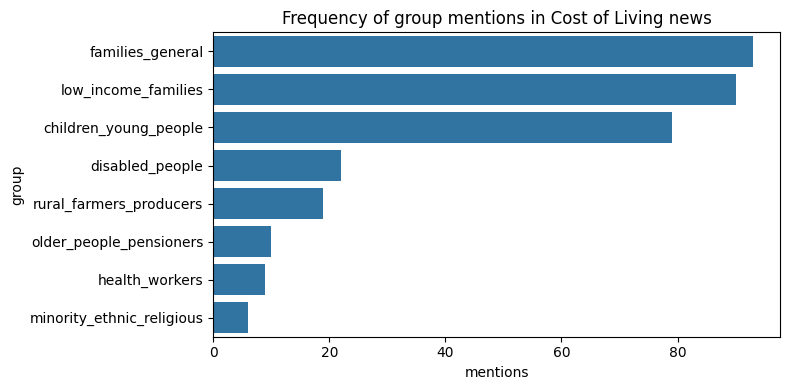

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(data=group_counts, x="mentions", y="group")
plt.title("Frequency of group mentions in Cost of Living news")
plt.tight_layout()
plt.show()

In [16]:
# Create month-level period from dates
df["year_month"] = df["dates"].dt.to_period("M")

# Build grouped table of mentions per month per group
gm = (
    df.explode("group_tags")
      .dropna(subset=["group_tags"])
      .groupby(["year_month", "group_tags"])
      .size()
      .reset_index(name="count")
)

gm.head()


,year_month,group_tags,count
0,2020-02,children_young_people,1
1,2020-02,disabled_people,2
2,2020-02,families_general,2
3,2020-02,low_income_families,1
4,2020-02,older_people_pensioners,1


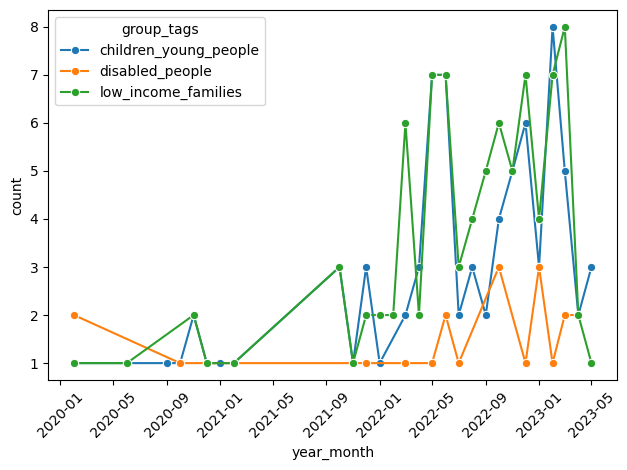

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick the groups we are interested in
subset = gm[gm["group_tags"].isin(["disabled_people", "children_young_people", "low_income_families"])].copy()

#  convert Period -> timestamp (continuous time axis)
subset["year_month"] = subset["year_month"].dt.to_timestamp()

# sort by time
subset = subset.sort_values("year_month")

sns.lineplot(data=subset, x="year_month", y="count", hue="group_tags", marker="o")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Output some files for records

In [18]:
df[["dates", "titles", "group_tags"]].to_csv("articles_with_group_tags.csv", index=False)
group_counts.to_csv("group_mentions_overall.csv", index=False)
coverage.to_csv("group_coverage_by_articles.csv", index=False)
co.to_csv("group_co_mentions.csv", index=False)

In [19]:
print(subset.dtypes)
print(subset.head())

year_month    datetime64[ns]
group_tags            object
count                  int64
dtype: object
   year_month             group_tags  count
0  2020-02-01  children_young_people      1
1  2020-02-01        disabled_people      2
3  2020-02-01    low_income_families      1
8  2020-06-01  children_young_people      1
10 2020-06-01    low_income_families      1


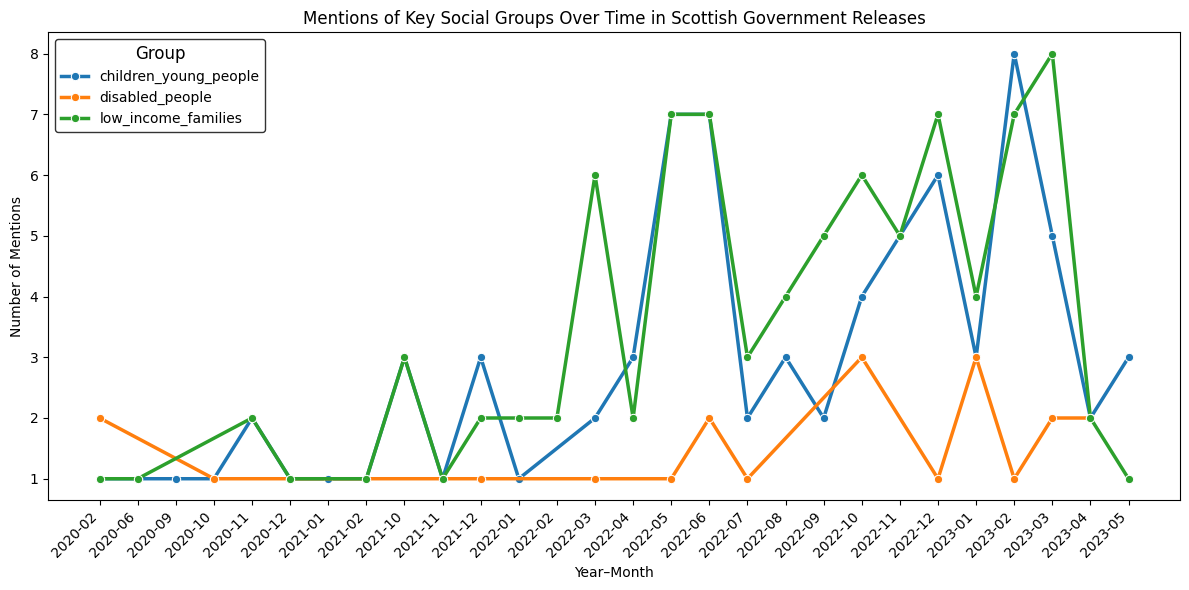

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select groups  to plot
groups_to_plot = ["disabled_people", "children_young_people", "low_income_families"]

# Filter the aggregated table
subset = gm[gm["group_tags"].isin(groups_to_plot)].copy()

# Convert Period to string for plotting
subset["year_month"] = subset["year_month"].astype(str)

# Ensure chronological ordering
subset = subset.sort_values("year_month")


plt.figure(figsize=(12, 6))  # larger figure for clarity

sns.lineplot(data=subset, x="year_month", y="count", hue="group_tags", marker="o", linewidth=2.5)

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.xlabel("Year–Month")
plt.ylabel("Number of Mentions")
plt.title("Mentions of Key Social Groups Over Time in Scottish Government Releases")

# Clear legend formatting
plt.legend(title="Group", title_fontsize=12, fontsize=10, frameon=True, facecolor="white", edgecolor="black")

plt.tight_layout()
plt.show()